In [1]:
import sys

## find 'core' package
sys.path.insert(0, '../..')

sys.version

'3.7.3 (default, Mar 27 2019, 09:23:15) \n[Clang 10.0.1 (clang-1001.0.46.3)]'

In [2]:
import pandas as pd

from core.models import unit
from core.models.table import Table
from core.factories import column_factory

In [3]:
from core.generators.label_generator import LabelGenerator
from core.generators.unit_generator import UnitGenerator
from core.generators.column_generator import ColumnGenerator
from core.generators.table_generator import TableGenerator

In [4]:
vocab = [ c for c in 'abcdefghijklmnopqrstuvwxyz' ]

index_to_char = dict([ (i, c) for i, c in enumerate(vocab) ])
char_to_index = dict([ (c, i) for i, c in enumerate(vocab) ])

label_generator = LabelGenerator(index_to_char)
unit_generator = UnitGenerator(unit.get_unit_lookup())

column_generator = ColumnGenerator(label_generator, unit_generator)

In [5]:
table_1 = Table()

table_1.set_id('1')
table_1.n_spaces_between_columns = 1
table_1.max_number_of_labels = 10
table_1.columns = [ 
    column_factory.create_column(
        order = 0,
        min_label_length = 2,
        max_label_length = 12,
        max_unit_length = 6,
        max_number_of_label_parts = 4
    ),
    column_factory.create_column(
        order = 1,
        min_label_length = 4,
        max_label_length = 15,
        max_unit_length = 6,
        max_number_of_label_parts = 3
    ),
    column_factory.create_column(
        order = 2,
        min_label_length = 2,
        max_label_length = 12,
        max_unit_length = 6,
        max_number_of_label_parts = 4
    )
]

table_2 = Table()

table_2.set_id('2')
table_2.n_spaces_between_columns = 3
table_2.max_number_of_labels = 10
table_2.columns = [ 
    column_factory.create_column(
        order = 0,
        min_label_length = 2,
        max_label_length = 12,
        max_unit_length = 6,
        max_number_of_label_parts = 4
    ),
    column_factory.create_column(
        order = 1,
        min_label_length = 4,
        max_label_length = 15,
        max_unit_length = 6,
        max_number_of_label_parts = 3
    ),
    column_factory.create_column(
        order = 2,
        min_label_length = 2,
        max_label_length = 12,
        max_unit_length = 6,
        max_number_of_label_parts = 4
    )
]

table_3 = Table()

table_3.set_id('3')
table_3.n_spaces_between_columns = 5
table_3.max_number_of_labels = 10
table_3.columns = [ 
    column_factory.create_column(
        order = 0,
        min_label_length = 2,
        max_label_length = 12,
        max_unit_length = 6,
        max_number_of_label_parts = 4
    ),
    column_factory.create_column(
        order = 1,
        min_label_length = 4,
        max_label_length = 15,
        max_unit_length = 6,
        max_number_of_label_parts = 3
    ),
    column_factory.create_column(
        order = 2,
        min_label_length = 2,
        max_label_length = 12,
        max_unit_length = 6,
        max_number_of_label_parts = 4
    )
]

In [6]:
table_lookup = {}

table_lookup[table_1.get_id()] = {
    'table': table_1,
    'table_generator': TableGenerator(table_1, column_generator),
}

table_lookup[table_2.get_id()] = {
    'table': table_2,
    'table_generator': TableGenerator(table_2, column_generator),
}

table_lookup[table_3.get_id()] = {
    'table': table_3,
    'table_generator': TableGenerator(table_3, column_generator),
}

table_lookup_keys = list(table_lookup.keys())

In [7]:
examples = 1000

X = []
y = []

for table_id in table_lookup_keys:

    for _ in range(examples):
        options = table_lookup[table_id]
        
        _, x, _ = options['table_generator'].get_table()

        X.append(x)
        y.append(
            options['table'].get_split_targets()
        )

In [8]:
import matplotlib.pyplot as plt

In [9]:
w = 0
h = 0
for key in table_lookup.keys():
    table = table_lookup[key]['table']
    
    width, height = table.get_max_size()
    
    if width > w:
        w = width
        
    if height > h:
        h = height
        
def convert_text_to_img(X, h, w):
    X_t = [ ]
    for example in X:

        img = []
        for row in example:
            u = [ 0 if r == ' ' else 1 for r in row ]
            if len(u) < w:
                u = u + [ 0 for _ in range(w - len(u))]

            img.append(u)

        while len(img) < h:
            img.append([0 for _ in range(w)])

        X_t.append(img)
    
    return X_t

X_t = convert_text_to_img(X, h, w)

In [10]:
import numpy as np

In [11]:
from keras.utils import to_categorical

from keras.models import Sequential
from keras.metrics import MeanSquaredError

## conv
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten

## lstm
from keras.layers import Input, LSTM, Dense, Bidirectional, Dropout

Using TensorFlow backend.


In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_t, y_t = shuffle(np.array(X_t), np.array(y))
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=.05)

In [13]:
display(X_train.shape[1:])
display(y_train)

(40, 68)

array([[23, 49],
       [21, 45],
       [21, 45],
       ...,
       [23, 49],
       [21, 45],
       [21, 45]])

## LSTM

In [14]:
model_lstm = Sequential()

model_lstm.add(
    Bidirectional(
        LSTM(400, input_shape=X_train.shape[1:], return_sequences=True, kernel_initializer='random_normal')
    )
)
model_lstm.add(Dropout(0.35))

model_lstm.add(
    LSTM(400, return_sequences=True, kernel_initializer='random_normal')
)
model_lstm.add(Dropout(0.35))

model_lstm.add(
    LSTM(400, return_sequences=False, kernel_initializer='random_normal')
)
model_lstm.add(Dropout(0.35))

## FC
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(y_train.shape[1], activation='linear'))

In [15]:
model_lstm.compile(
    optimizer='adam',
    loss='mse',
    metrics = ['mean_squared_error']
)

In [16]:
model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=25
)

Train on 2850 samples, validate on 150 samples
Epoch 1/25
2850/2850 [==============================] - 35s 12ms/step - loss: 290.3344 - mean_squared_error: 290.3344 - val_loss: 13.7774 - val_mean_squared_error: 13.7774
Epoch 2/25
2850/2850 [==============================] - 33s 12ms/step - loss: 14.7846 - mean_squared_error: 14.7846 - val_loss: 7.2236 - val_mean_squared_error: 7.2236
Epoch 3/25
2850/2850 [==============================] - 33s 11ms/step - loss: 9.2858 - mean_squared_error: 9.2858 - val_loss: 7.1117 - val_mean_squared_error: 7.1117
Epoch 4/25
2850/2850 [==============================] - 30s 11ms/step - loss: 9.2704 - mean_squared_error: 9.2704 - val_loss: 7.0783 - val_mean_squared_error: 7.0783
Epoch 5/25
2850/2850 [==============================] - 35s 12ms/step - loss: 9.0196 - mean_squared_error: 9.0196 - val_loss: 7.0661 - val_mean_squared_error: 7.0661
Epoch 6/25
2850/2850 [==============================] - 34s 12ms/step - loss: 9.1621 - mean_squared_error: 9.1621 -

In [17]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 40, 800)           1500800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 800)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 400)           1921600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

In [18]:
def split_file(indexes, text):

    splits = []

    previous_index = -1
    for index in filter(lambda x: x > 0, indexes):
        for row in text:
            if previous_index > 0:
                splits.append(row[previous_index:index].tolist())
            else:
                splits.append(row[:index].tolist())

        previous_index = index

    if previous_index > 0:
        for row in text:
            splits.append(row[previous_index:].tolist())
            
    if len(splits) == 0:
        return text
    
    _max = np.max([
        len(row)
        for row in splits
    ])

    formatted = []
    for row in splits:
        while len(row) < _max:
            row.append(0)

        formatted.append(row)
        
    return formatted

## Holdouts

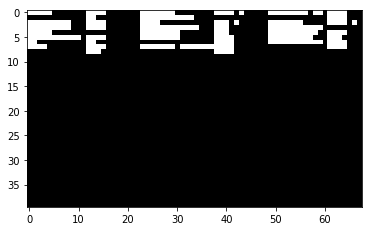

[21, 45] [23, 49]


In [19]:
options = table_lookup[table_3.get_id()]
_, x_ho, _ = options['table_generator'].get_table()

X_ho = np.array(convert_text_to_img([x_ho], h, w))

plt.imshow(X_ho[0], cmap='gray')
plt.show()

indexes = [
    int(round(y))
    for y
    in model_lstm.predict(X_ho)[0]
]

targets = options['table'].get_split_targets()
print(indexes, targets)

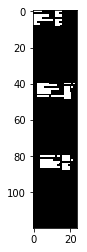

In [20]:
formatted = split_file(indexes, X_ho[0])

plt.imshow(formatted, cmap='gray')
plt.show()

## Conv

In [21]:
model_conv = Sequential()

model_conv.add(
    Conv1D(15, activation='relu', kernel_size=3, input_shape=X_train.shape[1:], padding='same')
)
model_conv.add(MaxPool1D(2, padding='same'))

model_conv.add(
    Conv1D(15, activation='relu', kernel_size=5, padding='same')
)
model_conv.add(
    MaxPool1D(2, padding='same')
)

model_conv.add(Flatten())

## FC
model_conv.add(Dense(50, activation='relu'))
model_conv.add(Dense(y_train.shape[1], activation='linear'))

In [22]:
model_conv.compile(
    optimizer='adam',
    loss='mse',
    metrics = ['mean_squared_error']
)

In [23]:
model_conv.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=50
)

Train on 2850 samples, validate on 150 samples
Epoch 1/50
2850/2850 [==============================] - 0s 169us/step - loss: 1047.3729 - mean_squared_error: 1047.3729 - val_loss: 625.2926 - val_mean_squared_error: 625.2926
Epoch 2/50
2850/2850 [==============================] - 0s 88us/step - loss: 278.6199 - mean_squared_error: 278.6199 - val_loss: 166.8662 - val_mean_squared_error: 166.8662
Epoch 3/50
2850/2850 [==============================] - 0s 89us/step - loss: 110.8854 - mean_squared_error: 110.8854 - val_loss: 107.3874 - val_mean_squared_error: 107.3874
Epoch 4/50
2850/2850 [==============================] - 0s 94us/step - loss: 64.8504 - mean_squared_error: 64.8504 - val_loss: 56.0381 - val_mean_squared_error: 56.0381
Epoch 5/50
2850/2850 [==============================] - 0s 92us/step - loss: 34.9717 - mean_squared_error: 34.9717 - val_loss: 28.2353 - val_mean_squared_error: 28.2353
Epoch 6/50
2850/2850 [==============================] - 0s 85us/step - loss: 20.3450 - mean_s

In [24]:
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 15)            3075      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 15)            1140      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 15)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

## Holdouts

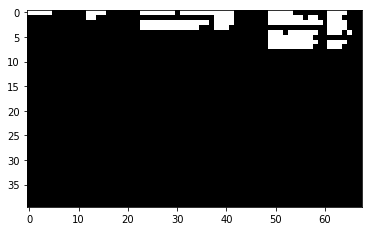

[23, 49] [23, 49]


In [26]:
options = table_lookup[table_3.get_id()]
_, x_ho, _ = options['table_generator'].get_table()

X_ho = np.array(convert_text_to_img([x_ho], h, w))

plt.imshow(X_ho[0], cmap='gray')
plt.show()

indexes = [
    int(round(y))
    for y
    in model_conv.predict(X_ho)[0]
]

targets = options['table'].get_split_targets()
print(indexes, targets)

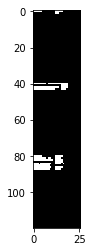

In [27]:
formatted = split_file(indexes, X_ho[0])

plt.imshow(formatted, cmap='gray')
plt.show()